<a href="https://colab.research.google.com/github/bdandersen-berkeley/mids/blob/working/W207/homework/brad_andersen_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Topic Classification

### Brad Andersen
### MIDS W207
### July 8, 2019 

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [0]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## Question 1

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def head_training_data(num_examples = 5):
    '''
    Prints the first specified number of newsgroup training data labels and text.

    Arguments
    ---------
    num_examples: int
    
    Number of newsgroup training data labels and text to print (default: 5)
    '''

    assert isinstance(num_examples, int), "num_examples must be of type int"
    assert num_examples >= 0, "num_examples must be greater than or equal to 0"

    for i in range(num_examples):
        print("+++++ newsgroups_train[", i, "]", sep = "")
        print("Label:", newsgroups_train.target_names[train_labels[i]])
        print("Text:\n-----\n", train_data[i], "\n-----\n")

# Print the first five newsgroup training data's labels and text
head_training_data()

+++++ newsgroups_train[0]
Label: comp.graphics
Text:
-----
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 
-----

+++++ newsgroups_train[1]
Label: talk.religion.misc
Text:
-----
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes 

## Question 2

 Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

### Question 2a

The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.


In [4]:
# Learn the training vocabulary and create the training term matrix
q2a_vectorizer = CountVectorizer()
q2a_term_matrix = q2a_vectorizer.fit_transform(train_data)

# What is the size of the vocabulary?
print("Vocabulary size:", len(q2a_vectorizer.vocabulary_), "words")

# What is the average number of non-zero features per example?
average_nonzero_features = q2a_term_matrix.data.sum() / len(train_data)
print("Average number of non-zero features per example: %.4f" % average_nonzero_features, "features")

# What fraction of the entries in the matrix are non-zero?
fraction_nonzero_entries = \
    q2a_term_matrix.nnz / (q2a_term_matrix.shape[0] * q2a_term_matrix.shape[1])
print("Fraction of entries in matrix that are non-zero: %.4f" % fraction_nonzero_entries)

Vocabulary size: 26879 words
Average number of non-zero features per example: 185.4336 features
Fraction of entries in matrix that are non-zero: 0.0036


### Question 2b

What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

In [5]:
# What are the 0th and last feature strings (in alphabetical order)?
assert len(q2a_vectorizer.vocabulary_) > 0, "No features exist"
print("First feature string:", q2a_vectorizer.get_feature_names()[0])
print("Last feature string:", q2a_vectorizer.get_feature_names()[len(q2a_vectorizer.vocabulary_) - 1])

First feature string: 00
Last feature string: zyxel


### Question 2c

Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

In [6]:
# Specify the training vocabulary and create the training term matrix
q2c_vocabulary = ["atheism", "graphics", "space", "religion"]
q2c_vectorizer = CountVectorizer(vocabulary =  q2c_vocabulary)
q2c_term_matrix = q2c_vectorizer.fit_transform(train_data)

# Confirm the training vectors are appropriately shaped.  The training term matrix should have
# a shape whose first element is the same size as that of the previous training term matrix
# (q2a_term_matrix), and whose second element should be the length of the specified vocabulary
# (q2c_vocabulary).
assert q2c_term_matrix.shape[0] == q2a_term_matrix.shape[0], "Number of raw documents should be of same size"
assert q2c_term_matrix.shape[1] == len(q2c_vocabulary), "Training term matrix shape does not correspond to the vocabulary length"

# What fraction of the entries in the matrix are non-zero?
fraction_nonzero_entries = \
    q2c_term_matrix.nnz / (q2c_term_matrix.shape[0] * q2c_term_matrix.shape[1])
print("Fraction of entries in matrix that are non-zero: %.4f" % fraction_nonzero_entries)

Fraction of entries in matrix that are non-zero: 0.0671


### Question 2d

Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

In [7]:
# Ensure that the behavior of the "analyzer" and "ngram_range" parameters passed to the 
# CountVectorizer are understood.  Parameter values of "word" and (1, 1), respectively, should
# yield the same size vocabulary as that identified in Question 2a.
q2d_vectorizer = CountVectorizer(analyzer = "word", ngram_range = (1, 1))
q2d_term_matrix = q2d_vectorizer.fit_transform(train_data)
assert len(q2a_vectorizer.vocabulary_) == len(q2d_vectorizer.vocabulary_), "Lengths of q2a and q2d vectorizer vocabularies are not equal"

# Initialize CountVectorizers with character ngram min and max lengths of (2, 2), (3, 3) and 
# (2, 3), and identify the size of the resulting vocabularies once trained on the training data
for t in [(2, 2), (3, 3), (2, 3)]:
    q2d_vectorizer = CountVectorizer(analyzer = "char", ngram_range = t)
    q2d_term_matrix = q2d_vectorizer.fit_transform(train_data)
    print("ngram limits (min and max characters):", t, "- Vocabulary size:", \
        len(q2d_vectorizer.vocabulary_), "ngrams")

ngram limits (min and max characters): (2, 2) - Vocabulary size: 3291 ngrams
ngram limits (min and max characters): (3, 3) - Vocabulary size: 32187 ngrams
ngram limits (min and max characters): (2, 3) - Vocabulary size: 35478 ngrams


### Question 2e

Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

In [8]:
# Create and train a vectorizer to prune words that appear in fewer than 10 documents 
q2e_vectorizer = CountVectorizer(min_df = 10)
q2e_term_matrix = q2e_vectorizer.fit_transform(train_data)

# What size vocabulary does this yield?
print("Minimum document frequency: 10 words - Vocabulary size:", \
    len(q2e_vectorizer.vocabulary_), "words")

Minimum document frequency: 10 words - Vocabulary size: 3064 words


### Question 2f

Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [9]:
# Create and train vectorizers on both training and dev data 
q2f_train_vectorizer = CountVectorizer()
q2f_dev_vectorizer = CountVectorizer()
q2f_train_term_matrix = q2f_train_vectorizer.fit_transform(train_data)
q2f_dev_term_matrix = q2f_dev_vectorizer.fit_transform(dev_data)

# Identify how many words in the dev vocabulary do not exist in the training vocabulary
missing_from_train_data = 0
for w in q2f_dev_vectorizer.vocabulary_:
    if w not in q2f_train_vectorizer.vocabulary_:
        missing_from_train_data += 1 
    else: 
        pass

fraction_missing_from_train_data = missing_from_train_data / len(q2f_dev_vectorizer.vocabulary_)
print("Fraction of words in dev data missing from training vocabulary: %.4f" % \
    fraction_missing_from_train_data)

Fraction of words in dev data missing from training vocabulary: 0.2479


## Question 3


### K Nearest Neighbor Classifier

Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k.



In [11]:
# Create and train a vanilla (i.e. default) count vectorizer for training data.  Transform test
# data to a sparse matrix using the same vectorizer.
q3_vectorizer = CountVectorizer()
q3_train_term_matrix = q3_vectorizer.fit_transform(train_data)
q3_test_term_matrix = q3_vectorizer.transform(test_data)

# Report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier
q3_knn_classifier = KNeighborsClassifier()
q3_knn_classifier.fit(X = q3_train_term_matrix, y = train_labels)

predicted_labels = q3_knn_classifier.predict(X = q3_test_term_matrix)
print("KNN classifier f1 score (neighbors = 5): %.4f" % \
      metrics.f1_score(y_true = test_labels, y_pred = predicted_labels, average = "micro"))
print("Classification report:\n", \
     metrics.classification_report(y_true = test_labels, y_pred = predicted_labels, target_names = categories))

KNN classifier f1 score (neighbors = 5): 0.3885
Classification report:
                     precision    recall  f1-score   support

       alt.atheism       0.31      0.47      0.38       154
talk.religion.misc       0.60      0.41      0.48       204
     comp.graphics       0.50      0.38      0.43       195
         sci.space       0.21      0.27      0.24       124

          accuracy                           0.39       677
         macro avg       0.41      0.38      0.38       677
      weighted avg       0.43      0.39      0.40       677



Assuming that the "optimal value" refers to the KNN classifier's f1 score, computing f1 scores for classifiers with k (i.e. neighbors) values less than and greater than the `KNeighborsClassifier` default value of 5 helps identify where the optimal value is likely to lie.

Additionally, values associated with the size of the test data are leveraged.

In [23]:
TEST_K_VALUES = [1, 4, 6, 10, 50, len(test_labels) // 3, len(test_labels) // 2, len(test_labels) - 1]

for k in TEST_K_VALUES:
  test_knn_classifier = KNeighborsClassifier(n_neighbors = k)
  test_knn_classifier.fit(X = q3_train_term_matrix, y = train_labels)
  predicted_labels = test_knn_classifier.predict(X = q3_test_term_matrix)
  print("KNN classifier f1 score (neighbors = %3d): %.4f" % \
      (k, metrics.f1_score(y_true = test_labels, y_pred = predicted_labels, average = "micro")))


KNN classifier f1 score (neighbors =   1): 0.4151
KNN classifier f1 score (neighbors =   4): 0.3914
KNN classifier f1 score (neighbors =   6): 0.3826
KNN classifier f1 score (neighbors =  10): 0.4047
KNN classifier f1 score (neighbors =  50): 0.4417
KNN classifier f1 score (neighbors = 225): 0.4727
KNN classifier f1 score (neighbors = 338): 0.4564
KNN classifier f1 score (neighbors = 676): 0.4106


I attempted to create an algorithm that identified the optimal k value by ascending and descending toward a higher f1 score based upon the prior k value's calculations, but the fact that the f1 score is non-linear made the algorithm more complicated than it was worth.  A simple line chart might suffice.

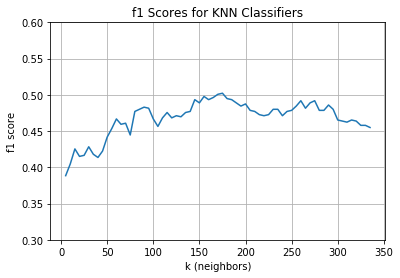

Rough optimal k value: 175, f1 value: 0.502216


In [43]:
k_f1 = []
rough_optimal_k = 5
rough_maximum_f1 = 0.0

for k in range(rough_optimal_k, len(test_labels) // 2, 5):
  test_knn_classifier = KNeighborsClassifier(n_neighbors = k)
  test_knn_classifier.fit(X = q3_train_term_matrix, y = train_labels)
  predicted_labels = test_knn_classifier.predict(X = q3_test_term_matrix)
  f1 = metrics.f1_score(y_true = test_labels, y_pred = predicted_labels, average = "micro")
  
  # Append the k-f1 tuple to the list, and check whether a maximum f1 value has been identified
  k_f1.append((k, f1))
  if f1 > rough_maximum_f1:
    rough_maximum_f1 = f1
    rough_optimal_k = k

plt.plot([x[0] for x in k_f1], [y[1] for y in k_f1])
plt.xlabel("k (neighbors)")
plt.ylabel("f1 score")
plt.title("f1 Scores for KNN Classifiers")
plt.ylim(0.3, 0.6)
plt.grid(True)
plt.show()

print("Rough optimal k value: %3d, KNN classifier's f1 value: %4f" % (rough_optimal_k, rough_maximum_f1))

Having identified the maximum f1 metric and its corresponding k value, we'll attempt to find a more accurate number of nearest neighbors for the classifier by calculating f1 values using classifiers with k values in a range around the previous, rough optimal k.

In [46]:
optimal_k = rough_optimal_k
maximum_f1 = 0.0

# Iterate through a range of k values to either side of the previously-identified (i.e. rough)
# optimal k
for k in range(rough_optimal_k - 10, rough_optimal_k + 10):
  test_knn_classifier = KNeighborsClassifier(n_neighbors = k)
  test_knn_classifier.fit(X = q3_train_term_matrix, y = train_labels)
  predicted_labels = test_knn_classifier.predict(X = q3_test_term_matrix)
  f1 = metrics.f1_score(y_true = test_labels, y_pred = predicted_labels, average = "micro")
  
  # Check whether a maximum f1 value has been identified
  if f1 > maximum_f1:
    maximum_f1 = f1
    optimal_k = k

print("Optimal k value: %3d, KNN classifier's f1 value: %4f" % (optimal_k, maximum_f1))

Optimal k value: 176, KNN classifier's f1 value: 0.508124


Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [0]:
#def P3():
### STUDENT START ###

### STUDENT END ###
#P3()

ANSWER:

## Question 4

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [0]:
#def P4():
### STUDENT START ###

### STUDENT END ###
#P4()

ANSWER:

## Question 5

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [0]:
#def empty_preprocessor(s):
#    return s

#def better_preprocessor(s):
### STUDENT START ###

### STUDENT END ###

#def P5():
### STUDENT START ###

### STUDENT END ###
#P5()

## Question 6

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [0]:
#def P6():
    # Keep this random seed here to make comparison easier.
    #np.random.seed(0)

    ### STUDENT START ###
    
    ### STUDENT END ###
#P6()

## Question 7

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [0]:
#def P7():
### STUDENT START ###

## STUDENT END ###
#P7()

ANSWER:

## Question 8 - Extra Credit

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.